In [67]:
# import sys
# sys.path.append("../")
from lib.clean import names_to_title_case
import pandas as pd
import numpy as np
import networkx as nx
from itertools import combinations
import os
import seaborn as sns
import statistics as stat
from collections import Counter
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from community import community_louvain
import random

In [68]:
def join_names(df):
    df.loc[:, "name"] = df.first_name.str.cat(df.last_name, sep=" ")
    return df.pipe(names_to_title_case, ["name"])

In [69]:
def read_allegations_ipm():
    df = pd.read_csv("../data/analysis/cprr_new_orleans_pd_ipm.csv")
    return df

df_allegation_ipm = read_allegations_ipm()

df_allegation_ipm = df_allegation_ipm.rename(columns={"pib_control_number": "tracking_id", "officer_sex_x": "officer_x", "officer_race_x": "officer_race", 
                                                      "title": "rank_desc", "officer_division_x": "officer_division", "officer_sub_division_a_x": "officer_sub_division_a"})

df_allegation_ipm.loc[:, "disposition"] = df_allegation_ipm.disposition_nopd.str.lower().str.replace(r"resigned(.+)", "sustained", regex=True)
df_allegation_ipm = df_allegation_ipm[df_allegation_ipm.disposition.isin(["sustained"])]
df_allegation_ipm.disposition.unique()

df_allegation_ipm = df_allegation_ipm.pipe(join_names)
# df_allegation_ipm = df_allegation_ipm[["tracking_id", "uid", "first_name", "last_name", "birth_year", "officer_division", "officer_sub_division_a", "rank_desc",
#                                        "citizen_age", "citizen_sex", "citizen_race", "allegation", "allegation_directive", "occurred_date", "county"]]

df_allegation_ipm = df_allegation_ipm[["tracking_id", "uid", "name"]]



In [70]:
def read_allegations_da():
    df = pd.read_csv("../data/clean/cprr_new_orleans_da_2016_2020.csv")
    return df

df_allegation_da = read_allegations_da()
df_allegation_da = df_allegation_da.pipe(join_names)



df_allegation_da.loc[:, "disposition"] = df_allegation_da.disposition.str.replace(r"(.+)?sustained(.+)?", "sustained", regex=True)
df_allegation_da = df_allegation_da[df_allegation_da.disposition.isin(["sustained"])]
df_allegation_da.disposition.unique()
# df_allegation_da = df_allegation_da[["tracking_id", "uid", "first_name", "last_name", "race", "sex", "age", "citizen_age", "allegation"]]
df_allegation_da = df_allegation_da[["tracking_id", "uid", "name"]]

In [71]:
def read_uof():
    df = pd.read_csv("../data/clean/uof_new_orleans_pd_2016_2021.csv")
    return df

df_uof = read_uof()
df_uof = df_uof.pipe(join_names)
# df_uof = df_uof[["tracking_id", "uid", "first_name", "last_name", "use_of_force_level", "division", "unit"]] 
df_uof = df_uof[["tracking_id", "uid", "name"]] 

In [72]:
def read_sas():
    df = pd.read_csv("../data/clean/sas_new_orleans_pd_2010_2021.csv")
    return df

df_sas = read_sas()
df_sas = df_sas.pipe(join_names)
# df_sas = df_sas[["tracking_id", "uid", "first_name", "last_name", "stop_results"]]
df_sas = df_sas[["tracking_id", "uid", "name"]]

C:\Users\PC\AppData\Local\Temp\ipykernel_11956\1810966405.py:2: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/clean/sas_new_orleans_pd_2010_2021.csv")


In [73]:
def read_epr():
    df = pd.read_csv("../data/clean/pr_new_orleans_pd_2010_2022.csv")
    return df

df_epr = read_epr()
df_epr = df_epr.pipe(join_names)

df_epr = df_epr.rename(columns={"item_number": "tracking_id"})
df_epr = df_epr[["tracking_id", "uid", "name"]]

C:\Users\PC\AppData\Local\Temp\ipykernel_11956\1751215704.py:2: DtypeWarning: Columns (23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/clean/pr_new_orleans_pd_2010_2022.csv")


In [74]:
# def drop_rows_missing_names(df):
#     df.loc[:, "last_name"] = df.last_name.str.replace(r"((.+)?unknown(.+)?|none|complaint operator|not(.+)?nopd(.+)?)", "", regex=True)
#     return df[~((df.last_name.fillna("") == ""))]

# df_allegation_ipm = df_allegation_ipm.pipe(drop_rows_missing_names)
# df_allegation_da = df_allegation_da.pipe(drop_rows_missing_names)

In [75]:
# remove outliers 
df_allegation_ipm = df_allegation_ipm[~df_allegation_ipm.tracking_id.isin(df_allegation_ipm.tracking_id.value_counts().loc[lambda x: x >= 30 ].index)]
df_allegation_da = df_allegation_da[~df_allegation_da.tracking_id.isin(df_allegation_da.tracking_id.value_counts().loc[lambda x: x >= 30 ].index)]
df_uof = df_uof[~df_uof.tracking_id.isin(df_uof.tracking_id.value_counts().loc[lambda x: x >= 30 ].index)]
df_sas = df_sas[~df_sas.tracking_id.isin(df_sas.tracking_id.value_counts().loc[lambda x: x >= 30 ].index)]
df_epr = df_epr[~df_epr.tracking_id.isin(df_epr.tracking_id.value_counts().loc[lambda x: x >= 30 ].index)]



In [76]:
# filter out officers not in the allegation table
df_allegation = pd.concat([df_allegation_ipm, df_allegation_da], axis=0)

df_uof = df_uof[df_uof['uid'].isin(df_allegation['uid'])]
df_sas = df_sas[df_sas['uid'].isin(df_allegation['uid'])]
df_epr = df_epr[df_epr['uid'].isin(df_allegation['uid'])]

In [77]:
df = pd.concat([df_allegation, df_uof], axis=0)

df.shape

(9932, 3)

In [78]:
d0 = df.groupby('tracking_id').count()
d1 = d0[d0.uid > 1]
group_complaints = list(set(d1.index))


df["count"] = 1
df_perUID = df.drop_duplicates(subset=["tracking_id", "uid"])
df_perUID = df_perUID.pivot_table(index=["tracking_id"], values=["count"], aggfunc="sum").reset_index()
df_perUID = df_perUID.rename(columns={"count": "no_of_officers"})
df_perUID

dict_PerComplaint = dict(zip(df_perUID.tracking_id, df_perUID.no_of_officers))

g = nx.Graph()
for incident in group_complaints:
    numberPer = dict_PerComplaint.get(incident)
    node_pairs = list(combinations(df[df.tracking_id == incident]['uid'].tolist(), 2))
    for node_pair in node_pairs:
        if g.has_edge(node_pair[0], node_pair[1]):
            g[node_pair[0]][node_pair[1]]['weight'] += (1+1/numberPer)
        else:
            g.add_edge(node_pair[0], node_pair[1], weight = (1+1/numberPer))
    if group_complaints.index(incident)%100==0:
        value = str(group_complaints.index(incident)/len(group_complaints)*100)[:5] +  "% complete "
print ("\r ", value, end = " \r "),
print("\r 100.00% complete")

print(nx.info(g))

edgeList = list(g.edges)
toRemove = [nodes for nodes in edgeList if g[nodes[0]][nodes[1]]['weight'] <=2]
g.remove_edges_from(toRemove)
g.remove_nodes_from(list(nx.isolates(g)))

print(nx.info(g))

 100.00% complete  
Graph with 1144 nodes and 3542 edges
Graph with 863 nodes and 1546 edges


C:\Users\PC\AppData\Local\Temp\ipykernel_11956\579980390.py:28: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(g))
C:\Users\PC\AppData\Local\Temp\ipykernel_11956\579980390.py:35: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(g))


In [79]:
with open("edges.txt", "wb") as f:
    nx.write_edgelist(g, f)


In [80]:
comms = community_louvain.best_partition(g, randomize=0)
random.seed(1)

In [81]:
df.uid.nunique()

1281

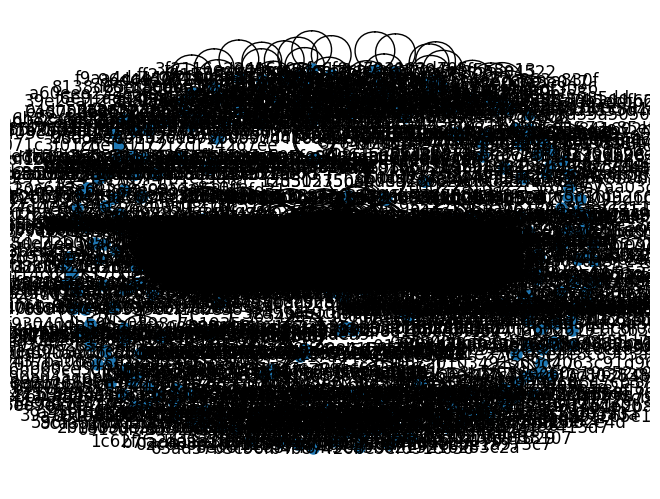

In [82]:
unique_coms = np.unique(list(comms.values()))
unique_coms

pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=True, node_size = 64, alpha = 1)
plt.show()

In [83]:
comm_df = pd.DataFrame.from_dict(comms, orient="index").reset_index()
comm_df = comm_df.rename(columns={comm_df.columns[1]: "community", "index": "uid"})

In [84]:
comm_df

,uid,community
0,8f6d7ab44307a42f99d071a653db66d5,0
1,ce096d232d18bf3041fd592d6cc9a367,1
2,8395755ca6f97480115870a0638c4f16,2
3,a60eee252cdfee82390f9e292049b2d1,3
4,cc8f65094b7e270f0337ede26fa9e047,4
...,...,...
858,eb7de9fe1a2c8f7093511608af3e77d0,23
859,04ec17b12264b442be8681d65939e061,22
860,36571ff0389f1b69af3abcbd6c7e9de0,203
861,579f2449cf2da7f412b607632f1f3558,203


In [85]:
comm_24 = comm_df[comm_df.community.astype(str).isin(["4"])]
comm_24

,uid,community
4,cc8f65094b7e270f0337ede26fa9e047,4


In [86]:
review_comms = df[df.tracking_id.isin(["ebf4a9f606deca124f12111f5873b0c5"])]
review_comms

,tracking_id,uid,name,count
